# Маркетинговая аналитика Яндекс.Афиши

## Задача

Помочь маркетологам Яндекс.Афиши отказаться от невыгодных источников трафика и перераспределить бюджет.

Выручка измеряется в условных единицах — у.е. Маржинальность сервиса — 100%.

## Описание данных

Имеем данные Яндекс.Афиши с июня 2017 по конец мая 2018 года.

Таблица **visits_log** (лог сервера с данными о посещениях сайта Яндекс.Афиши):
- Device — категория устройства пользователя
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника
- Start Ts — дата и время начала сессии
- Uid — уникальный идентификатор пользователя

Таблица **orders_log** (выгрузка всех заказов за этот период):
- Buy Ts — дата и время совершения заказа
- Revenue — выручка с заказа
- Uid — уникальный идентификатор пользователя

Таблица **costs** (статистика рекламных расходов):
- source_id — идентификатор рекламного источника
- dt — дата рекламного расхода
- costs — величина расхода

## Оглавление

### [Шаг 1. Загрузка и подготовка данных к анализу](#data_preprocessing)
### [Шаг 2. Расчёт метрик и построение графиков](#metrics_calculation)
- [Продуктовые метрики](#product)
- [Метрики электронной коммерции](#ecommerce)
- [Маркетинговые метрики](#marketing)

### [Шаг 3.  Выводы и рекомендации](#recommendation)

## Ход работы

#### Импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## <a id='data_preprocessing'>Шаг 1. Загрузка и подготовка данных к анализу</a>

In [2]:
def review_file(filename, title):
    '''
    Функция сохраняет данные в возвращаемую переменную
    и выводит необходимую информацию на экран.
    
    Аргументы:
        filename (str): путь к файлу.
        
        title (str): название таблицы.
    '''
    
    table = pd.read_csv(filename)
    
    print('\033[1m'
          + f'Общая информация о таблице {title}:'
          + '\033[0m')
    print()
    table.info()
    print()
    
    if table.shape[0] > 10:
        print('\033[1m' 
              + f'Первые 10 строк таблицы {title}:'
              + '\033[0m')
        display(table.head(10))
    else:
        print('\033[1m'
              + f'Таблица {title}:'
              + '\033[0m')
        display(table)
        
    print('\033[1m'
          + f'Количество пропусков в каждом столбце таблицы {title}:'
          + '\033[0m')
    display(pd.DataFrame(table.isna().sum()))
    
    print('\033[1m'
          + f'Число дубликатов в таблице {title}: {table.duplicated().sum()}'
          + '\033[0m')
    
    return table

#### Откроем файлы с данными и изучим их.

In [3]:
visits = review_file('/datasets/visits_log.csv', 'visits_log')

Общая информация о таблице visits_log:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB

Первые 10 строк таблицы visits_log:


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


Количество пропусков в каждом столбце таблицы visits_log:


,0
Device,0
End Ts,0
Source Id,0
Start Ts,0
Uid,0


Число дубликатов в таблице visits_log: 0


Датафрейм **visits** состоит из 359 400 строк и 5 столбцов. Названия столбцов представлены в неудобном для анализа виде. Пропусков и дубликатов нет. Тип данных в столбцах *End Ts* и *Start Ts* — *object*, а не *datetime*.

***

In [4]:
orders = review_file('/datasets/orders_log.csv', 'orders_log')

Общая информация о таблице orders_log:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB

Первые 10 строк таблицы orders_log:


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


Количество пропусков в каждом столбце таблицы orders_log:


,0
Buy Ts,0
Revenue,0
Uid,0


Число дубликатов в таблице orders_log: 0


Датафрейм **orders** состоит из 50 415 строк и 3 столбцов. Названия столбцов представлены в неудобном для анализа виде. Пропусков и дубликатов нет. Тип данных в столбце *Buy Ts* — *object*, а не *datetime*.

***

In [5]:
costs = review_file('/datasets/costs.csv', 'costs')

Общая информация о таблице costs:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB

Первые 10 строк таблицы costs:


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


Количество пропусков в каждом столбце таблицы costs:


,0
source_id,0
dt,0
costs,0


Число дубликатов в таблице costs: 0


Датафрейм **costs** состоит из 2 542 строк и 3 столбцов. Пропусков и дубликатов нет. Тип данных в столбце *dt* — *object*, а не *datetime*.

***

#### Приведём названия столбцов датафреймов к удобному для анализа виду.

In [6]:
visits = visits.rename(columns={
    'Device': 'device',
    'End Ts': 'end_ts',
    'Source Id': 'source_id',
    'Start Ts': 'start_ts',
    'Uid': 'uid'
})

orders = orders.rename(columns={
    'Buy Ts': 'buy_ts',
    'Revenue': 'revenue',
    'Uid': 'uid'
})

costs = costs.rename(columns={'dt': 'costs_date'})

#### Приведём типы данных в столбцах, подразумевающих значения типа *datetime*.

In [7]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%dT%H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%dT%H:%M:%S')
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%dT%H:%M:%S')
costs['costs_date'] = pd.to_datetime(costs['costs_date'], format='%Y-%m-%d')

### Вывод

1. Датафрейм **visits** состоит из 359 400 строк и 5 столбцов. Названия столбцов представлены в неудобном для анализа виде. Пропусков и дубликатов нет. Тип данных в столбцах *End Ts* и *Start Ts* — *object*, а не *datetime*.
2. Датафрейм **orders** состоит из 50 415 строк и 3 столбцов. Названия столбцов представлены в неудобном для анализа виде. Пропусков и дубликатов нет. Тип данных в столбце *Buy Ts* — *object*, а не *datetime*.
3. Датафрейм **costs** состоит из 2 542 строк и 3 столбцов. Пропусков и дубликатов нет. Тип данных в столбце *dt* — *object*, а не *datetime*.

Названия столбцов датафреймов были приведены к удобному для анализа виду.

Типы данных в столбцах, подразумевающих значения типа *datetime*, были приведены.

## <a id='metrics_calculation'>Шаг 2. Расчёт метрик и построение графиков</a>

### <a id='product'>Продуктовые метрики</a>

#### Рассчитаем метрики DAU, WAU и MAU.

In [8]:
visits['session_date'] = visits['start_ts'].dt.date
visits['session_week']  = visits['start_ts'].astype('datetime64[W]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')

daily_users = visits.groupby('session_date').agg({'uid': 'nunique'})
weekly_users = visits.groupby('session_week').agg({'uid': 'nunique'})
monthly_users = visits.groupby('session_month').agg({'uid': 'nunique'})

dau_total = daily_users.mean()
wau_total = weekly_users.mean()
mau_total = monthly_users.mean()

print('DAU =', int(dau_total))
print('WAU =', int(wau_total))
print('MAU =', int(mau_total))

DAU = 907
WAU = 5724
MAU = 23228


В день сайт Яндекс.Афиши посещает 907 уникальных пользователей, в неделю — 5 716, а в месяц — 23 228.

In [9]:
def draw_plot(series, title):
    '''
    Функция рисует график заданного объекта типа Series.
    
    Аргументы:
        series (pandas.core.series.Series): объект типа Series.
        
        title (str): тип распределения (по дням, по неделям или по месяцам).
    '''
    series.plot(figsize=(15, 6), linewidth=3, legend=None)
    plt.title(f'Пользовательская активность {title}', fontsize=15)
    plt.xlabel('Дата сессии', fontsize=15)
    plt.ylabel('Уникальные пользователи', fontsize=15)
    plt.tick_params(labelsize=14)
    plt.grid()
    plt.show()

#### Построим графики пользовательской активности по дням, неделям и месяцам соответственно. 

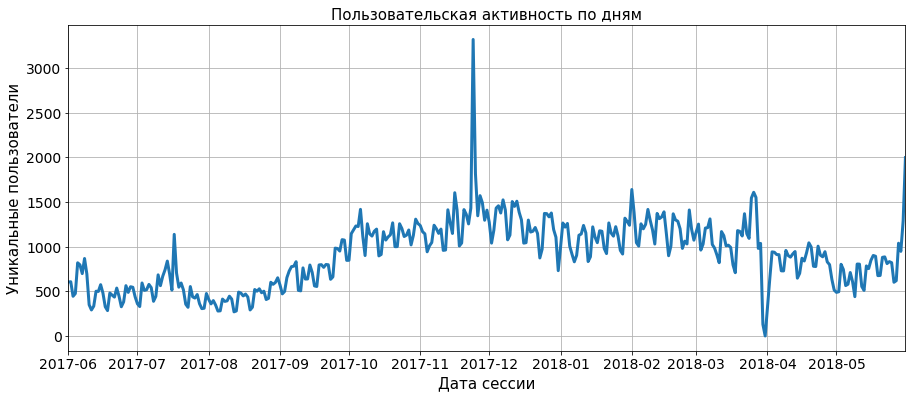

In [10]:
draw_plot(daily_users, 'по дням')

In [11]:
daily_users.sort_values(by='uid').head()

,uid
session_date,
2018-03-31,1
2018-03-30,131
2017-08-12,271
2017-08-05,280
2017-08-13,281


In [12]:
daily_users.sort_values(by='uid', ascending=False).head()

,uid
session_date,
2017-11-24,3319
2018-05-31,1997
2017-11-25,1817
2018-02-01,1640
2018-03-26,1609


Пользователи довольно стабильно посещают сайт с нелогичным скачком 24 ноября 2017 года. Возможно, в этот день происходила распродажа билетов на какое-то популярное мероприятие. 31 марта 2018 года сайт, скорее всего, не работал.

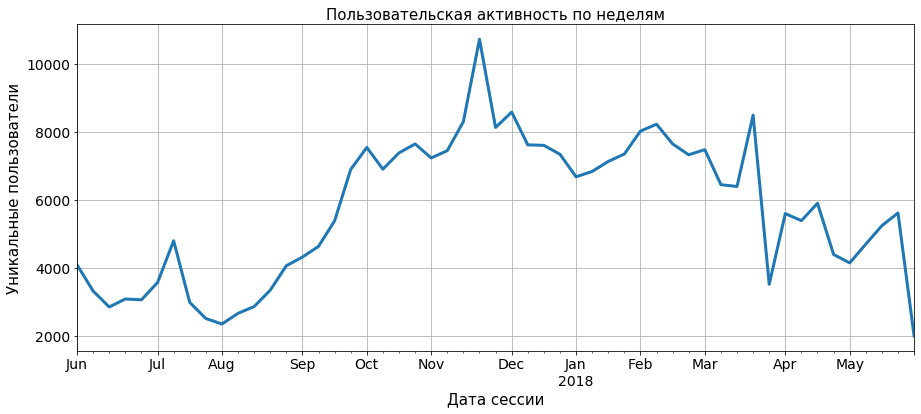

In [13]:
draw_plot(weekly_users, 'по неделям')

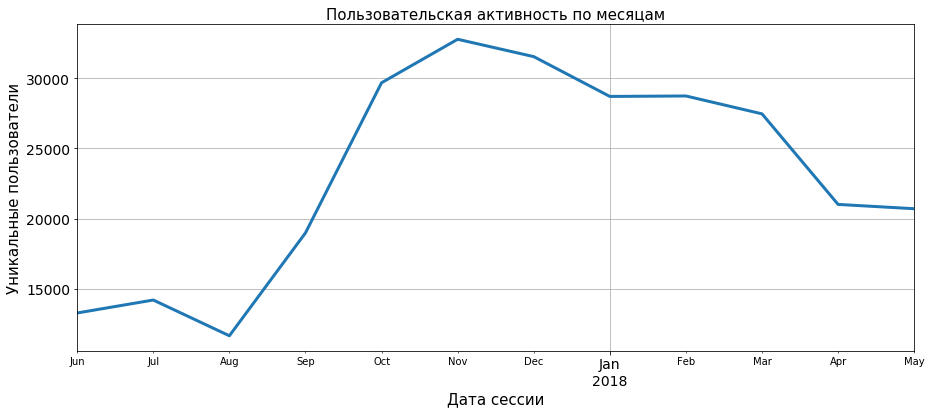

In [14]:
draw_plot(monthly_users, 'по месяцам')

Судя по активности по неделям и месяцам, популярность Афиши возросла в октябре 2018 года. Сайт особенно популярен в холодное время года. Однако, сильно опираться на происходящее в течении года не стоит. Скорее всего, это обычная сезонность сервиса.

#### Посчитаем регулярность посещения сайта (найдём метрику *sticky factor*).

In [15]:
sticky_wau = float((dau_total / wau_total * 100).round(2))
sticky_mau = float((dau_total / mau_total * 100).round(2))

print('sticky factor = DAU / WAU =', sticky_wau)
print('sticky factor = DAU / MAU =', sticky_mau)

sticky factor = DAU / WAU = 15.86
sticky factor = DAU / MAU = 3.91


Лояльность посетителей сайта плохая вне зависимости от подсчёта. Однако высоких показателей здесь и не ожидалось. Во-первых, у людей довольно редко бывает время на то, чтобы посещать мероприятия несколько раз в месяц и тем более несколько раз в неделю. Во-вторых, при наличие такового времени люди далеко не всегда будут искать мероприятие и покупать билет на него через сайт Яндекс.Афиши.

***

In [16]:
def make_column(period, columns, aggfunc):
    '''
    Функция возвращает среднее количество пользователей
    по всем значениям заданного параметра на заданном временном
    промежутке. Тип возвращаемого объекта: pandas.core.series.Series.
    
    Аргументы:
        period (str): временной период.
            Возможные значения: daily (день),
            weekly (неделя), monthly (месяц).
        
        columns (str): аргумент columns сводной таблицы.
        
        aggfunc (str): аргумент aggfunc сводной таблицы.
    '''
    
    # Определяем временной промежуток
    if period == 'daily':
        index = 'session_date'
    elif period == 'weekly':
        index = 'session_week'
    else:
        index = 'session_month'
    
    # Возвращаем среднее количество пользователей
    # по всем значениям заданного параметра
    # на заданном временном промежутке
    return (
        visits
        .pivot_table(index=index, columns=columns, values='uid', aggfunc=aggfunc)
        .mean()
        .round()
        .astype('int')
    )

In [17]:
def show_pivot(param, is_unique=True):
    '''
    Функция выводит сводную таблицу
    по трём временным промежуткам (день, неделя и месяц)
    
    Аргументы:
        param (str): рассматриваемый параметр.
            Возможные значения: device (устройство),
            source (источник).
        
        is_unique (bool): индикатор уникальности сессии.
    '''
    
    # Определяем рассматриваемый параметр
    if param == 'device':
        columns = 'device'
    elif param == 'source':
        columns = 'source_id'
    else:
        raise Exception('Задан неверный параметр.')
    
    # Определяем необходимость считать лишь уникальные сессии
    if is_unique:
        aggfunc = 'nunique'
    else:
        aggfunc = 'count'
    
    pivot_table = pd.DataFrame()
    pivot_table['daily_users'] = make_column('daily', columns, aggfunc)
    pivot_table['weekly_users'] = make_column('weekly', columns, aggfunc)
    pivot_table['monthly_users'] = make_column('monthly', columns, aggfunc)
    display(pivot_table.sort_values(by='daily_users', ascending=False))

#### Посмотрим, с каких устройств пользователи посещают сайт в тех же временных рамках.

In [18]:
show_pivot('device')

,daily_users,weekly_users,monthly_users
device,,,
desktop,659,4136,16725
touch,253,1637,6826


Пользователи посещают сайт с десктопных устройств в 2.5 раза чаще, нежели с мобильных.

#### Определим наиболее популярные рекламные источники.

In [19]:
show_pivot('source')

,daily_users,weekly_users,monthly_users
source_id,,,
4,275,1831,7766
3,233,1566,6759
5,176,1168,5018
2,121,716,2752
1,81,465,1819
9,36,238,987
10,26,167,707
6,1,1,1
7,1,1,3


Наиболее популярными рекламными источниками являются источники под идентификационными номерами 4, 3, 5 и 2. Также отметим абсолютно непопулярные источники под номерами 6 и 7.

#### Определим, сколько раз в день пользователи в среднем заходят на сайт.

In [20]:
daily_visits = visits.groupby('session_date').agg({'uid': ['nunique', 'count']})
daily_visits['sessions_per_user'] = (
    daily_visits.iloc[:, 1] / daily_visits.iloc[:, 0]
)

print('Пользователи в среднем заходят на сайт {} раза в день.'\
      .format(daily_visits['sessions_per_user'].mean().round(2)))

Пользователи в среднем заходят на сайт 1.08 раза в день.


Как было сказано выше, для сайта, предназначенного для поиска мероприятий, число неаномальное.

#### Добавим в датафрейм *visits* столбец с продолжительностью каждой сессии в секундах.

In [21]:
visits['session_duration'] = (
    (visits['end_ts'] - visits['start_ts'])
).dt.total_seconds().round().astype('int')

In [22]:
visits.query('session_duration < 0')[['start_ts', 'end_ts']]

,start_ts,end_ts
4181,2018-03-25 03:50:00,2018-03-25 03:18:00
177972,2018-03-25 03:55:00,2018-03-25 03:09:00


Заметим, что две сессии от 25 марта 2018 года начались раньше, чем закончились. При этом обе сессии выпали на время от 3 до 4 часов ночи. Возможно, данная ситуация — результат сбоя системы.

#### Избавимся от некорректных сессий.

In [23]:
visits = visits.drop([4181, 177972])

#### Взглянем на среднее, медиану и моду продолжительностей каждой сессии.

In [24]:
print('Среднее: ', visits['session_duration'].mean())
print('Медиана: ', visits['session_duration'].median())
print('Мода: ', visits['session_duration'].mode()[0])

Среднее:  643.0422873805642
Медиана:  300.0
Мода:  60


In [25]:
print('Доля сессий, близких к моде: ', \
      visits.query('40 < session_duration < 80').shape[0] / visits.shape[0])

Доля сессий, близких к моде:  0.14754951335288455


In [26]:
def define_bins(series): 
    if series.max() > 100:
        return 50
    elif series.max() > 500:
        return 100
    elif series.max() > 1000:
        return 200
    else:
        return 20

In [27]:
def draw_hist(series, title, xlabel, draw_lines=True, datetime=False):
    '''
    Функция рисует гистограмму заданного объекта типа Series.
    
    Аргументы:
        series (pandas.core.series.Series): объект типа Series.
        
        title (str): заголовок гистограммы.
        
        xlabel (str): подпись оси абсцисс.
        
        draw_lines (bool): нарисовать медиану, 5-ый и 95-ый перцентили.
        
        datetime (bool): индикатор типа данных datetime.
    '''
    
    # Определяем число корзин
    # Если данные имеют тип datetime
    if datetime:
        # Устанавливаем значение 100
        bins = 100
        # На всём отрезке
        range = (series.min(), series.max())
        # С поворотом чисел на отметках абсциссы
        labelrotation = 45
    # Иначе
    else:
        # Определяем оптимальное число корзин
        bins = define_bins(series)
        # Определяем отрезок от 0 до 99-го перцентиля
        range = (0, series.quantile(.99))
        # Не поворачивая числа на отметках абсциссы
        labelrotation = 0
    
    # Создаём фигуру
    plt.figure(figsize=(15, 6))
    # Строим гистограмму
    plt.hist(series,                                 # по Series
             range=range,                            # на определённом отрезке
             bins=bins,                              # с определённым числом корзин
             alpha=0.5,                              # с прозрачностью 0.5
             ec='black',                             # с чёрным цветом обводки
             color='green')                          # с зелёным цветом графика
    # Если необходимо нарисовать нарисовать медиану, 5-ый и 95-ый перцентили
    if draw_lines:
        plt.axvline(x=series.median(),               # рисуем медиану
                    linewidth=3,                     # с толщиной линий 3
                    color='red',                     # красного цвета
                    linestyle='--')                  # пунктирным стилем
        plt.axvline(x=series.quantile(.05),          # рисуем 5-ый перцентиль
                    linewidth=3, 
                    color='y',                       # тёмно-жёлтого цвета
                    linestyle='--')
        plt.axvline(x=series.quantile(.95),          # рисуем 95-ый перцентиль
                    linewidth=3, 
                    color='y', 
                    linestyle='--')
        # Добавляем легенду
        plt.legend(labels=['Медиана', '5-ый и 95-ый перцентили'], fontsize=15)
    # Увеличиваем числа на отметках осей
    plt.tick_params(labelsize=15)
    # Задаём угол поворота чисел на абсциссе
    plt.tick_params(labelrotation=labelrotation, axis='x')
    # Добавляем заголовок
    plt.title(title, fontsize=15)
    # Добавляем подпись оси абсцисс
    plt.xlabel(xlabel, fontsize=15)
    # Добавляем подпись оси ординат
    plt.ylabel('Число наблюдений', fontsize=15)
    # Рисуем сетку
    plt.grid()
    # Рисуем график
    plt.show()

#### Посмотрим на график распределения продолжительности пользовательских сессий за весь период.

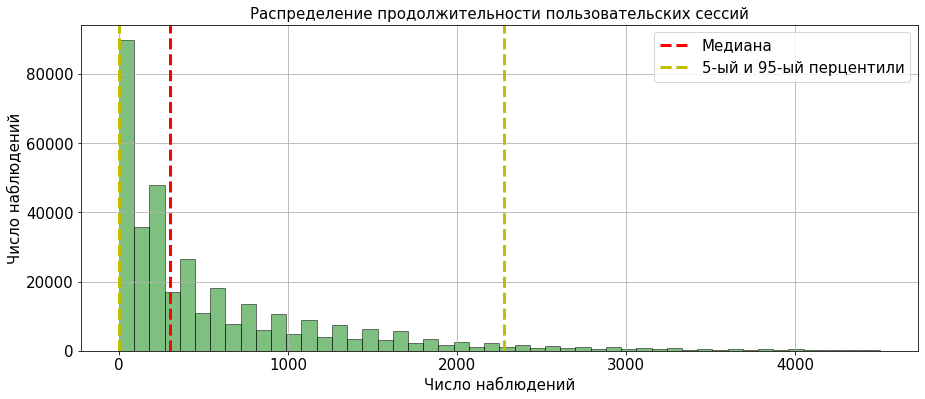

In [28]:
draw_hist(
    visits['session_duration'],
    'Распределение продолжительности пользовательских сессий',
    'Число наблюдений'
)

In [29]:
visits['session_duration'].describe()

count    359398.000000
mean        643.042287
std         997.105212
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: session_duration, dtype: float64

Имеем отнюдь не нормальное распределение, поэтому брать среднее за продолжительность типичной пользовательской сессии некорректно. Значения, близкие к моде, не составляют и 15% данных. Поэтому возьмём медиану как наиболее достоверный показатель. Предположение можно подкрепить логически: 5 минут — вполне достаточно, чтобы выбрать мероприятие, прочитать описание и, возможно, приобрести билет на него. Минута — слишком мало.

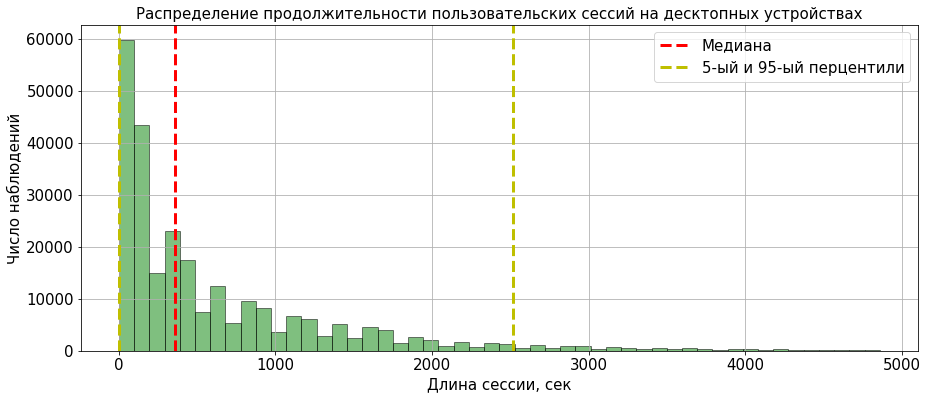

In [30]:
draw_hist(
    visits.query('device == "desktop"')['session_duration'],
    'Распределение продолжительности пользовательских сессий \
на десктопных устройствах',
    'Длина сессии, сек'
)

In [31]:
visits.query('device == "desktop"')['session_duration'].describe()

count    262565.000000
mean        703.312041
std        1067.030043
min           0.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       42660.000000
Name: session_duration, dtype: float64

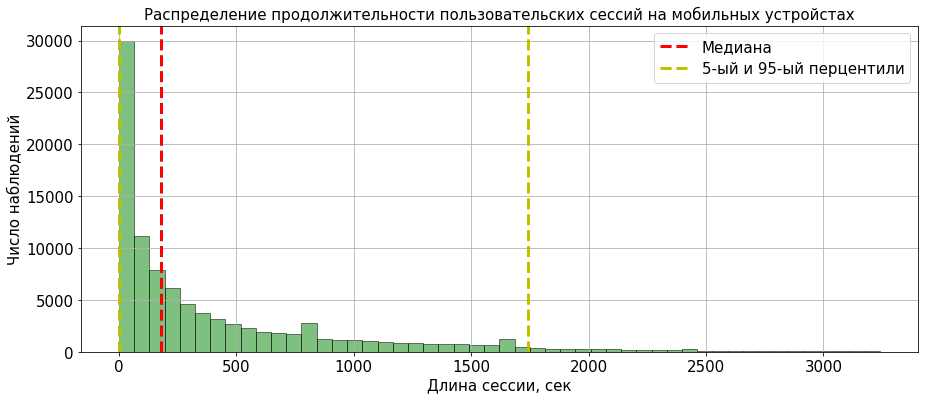

In [32]:
draw_hist(
    visits.query('device == "touch"')['session_duration'],
    'Распределение продолжительности пользовательских сессий \
на мобильных устройстах',
    'Длина сессии, сек'
)

In [33]:
visits.query('device == "touch"')['session_duration'].describe()

count    96833.000000
mean       479.619407
std        752.531533
min          0.000000
25%         60.000000
50%        180.000000
75%        600.000000
max      30840.000000
Name: session_duration, dtype: float64

In [34]:
print('ASL с десктопного устройства: ', \
      visits.query('device == "desktop"')['session_duration'].median())
print('ASL с мобильного устройства: ', \
      visits.query('device == "touch"')['session_duration'].median())

ASL с десктопного устройства:  360.0
ASL с мобильного устройства:  180.0


Ровно в 2 раза дольше пользователи проводят на сайте с дескоптных устройств. Возможно, читать описание мероприятий удобнее через компьютер или ноутбук. Возможно, минималистичный мобильный интерфейс способствует тому, что пользователь быстрее находит нужные мероприятия.

In [35]:
visits.pivot_table(index='source_id', values='session_duration', aggfunc='median')\
.sort_values(by='session_duration', ascending=False)

,session_duration
source_id,
1,600
2,420
6,420
10,300
3,240
4,240
5,240
9,240
7,180


Пользователи, пришедшие из источников под номерами 1, 2 и 6 проводят на сайте 7-10 минут, тогда как остальным достаточно 3-5 минут.

***

#### Найдём дату, когда пользователь впервые проявил активность на сайте, и сформируем по ней когорты.

In [36]:
visits['first_visit_ts'] =  visits.groupby('uid')['start_ts'].transform('min')

#### Выделим из столбцов *start_ts* и *first_visit_ts* месяцы.

In [37]:
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')
visits['first_visit_month'] = visits['first_visit_ts'].astype('datetime64[M]')

#### Для каждой строки датафрейма рассчитаем lifetime пользователя в рамках когорты.

In [38]:
visits['cohort_lifetime'] = (
    (visits['visit_month'] - visits['first_visit_month']) / np.timedelta64(1, 'M')
).round().astype('int')

#### Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни».

In [39]:
cohort_visitors = (
    visits.groupby(['first_visit_month', 'cohort_lifetime'], as_index=False)
).agg({'uid': 'nunique'})

#### Найдём исходное количество пользователей в когорте.

In [40]:
initial_visitors_count = (
    cohort_visitors
    .query('cohort_lifetime == 0')[['first_visit_month', 'uid']]
).rename(columns={'uid': 'cohort_visitors'})

#### Объединим данные по когортам с исходным количеством пользователей в когорте.

In [41]:
cohort_visitors = cohort_visitors.merge(initial_visitors_count, on='first_visit_month')

#### Рассчитаем Retention Rate. Разделим количество активных пользователей в каждый из месяцев на исходное число пользователей в когорте.

In [42]:
cohort_visitors['retention'] = cohort_visitors['uid'] / cohort_visitors['cohort_visitors']

#### Построим сводную таблицу.

In [43]:
retention_visitors_pivot = (
    cohort_visitors
    .pivot_table(index='first_visit_month',
                 columns='cohort_lifetime',
                 values='retention',
                 aggfunc='sum')
)

#### Создадим тепловую карту.

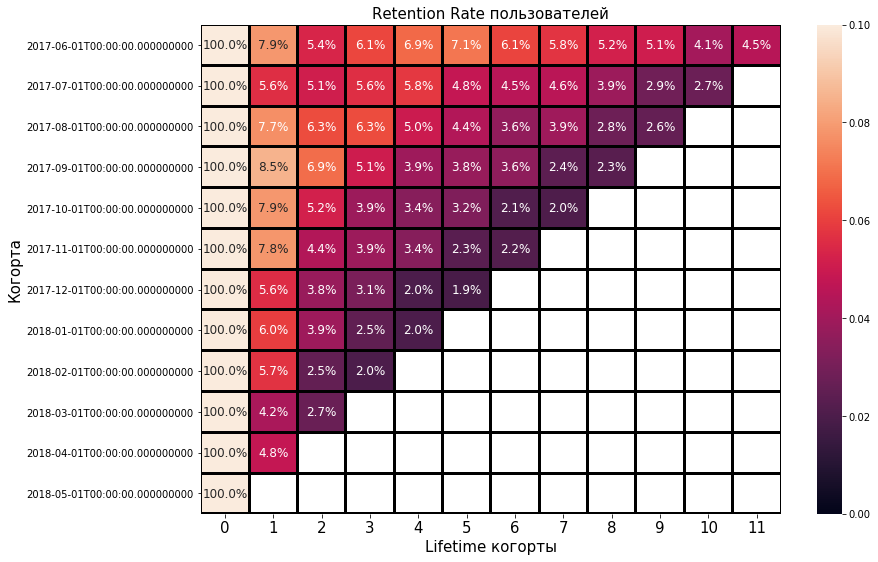

In [44]:
fig, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(retention_visitors_pivot, annot=True, fmt='.1%', linewidths=2,
            linecolor='black', vmin=0, vmax=0.1, ax=ax, annot_kws={'size': 12})
ax.set_title('Retention Rate пользователей', fontsize=15)
ax.set_xlabel('Lifetime когорты', fontsize=15)
ax.set_ylabel('Когорта', fontsize=15)
plt.tick_params(labelsize=15, axis='x')
plt.show()

Retention Rate достаточно низкий во всех когортах. В когорте июня 2017-го, то есть в самой первой когорте, он самый высокий. Временный рост данного показателя наблюдается только в когортах июня и июля 2017-го и приходится на осень.

### Вывод

В день сайт Яндекс.Афиши посещает 907 уникальных пользователей, в неделю — 5 716, а в месяц — 23 228, то есть: **DAU = 907**, **WAU = 5 716**, **MAU = 23 228**.

Пользователи довольно стабильно посещают сайт с нелогичным скачком 24 ноября 2017 года. Возможно, в этот день происходила распродажа билетов на какое-то популярное мероприятие. 31 марта 2018 года сайт, скорее всего, не работал.

Судя по активности по неделям и месяцам, популярность Афиши возросла в октябре 2018 года. Сайт особенно популярен в холодное время года. Однако, сильно опираться на происходящее в течении года не стоит. Скорее всего, это обычная сезонность сервиса.

Лояльность посетителей сайта плохая вне зависимости от подсчёта (**sticky factor = DAU / WAU = 15.88**, **sticky factor = DAU / MAU = 3.91**). Однако высоких показателей здесь и не ожидалось. Во-первых, у людей довольно редко бывает время на то, чтобы посещать мероприятия несколько раз в месяц и тем более несколько раз в неделю. Во-вторых, при наличие такового времени люди далеко не всегда будут искать мероприятие и покупать билет на него через сайт Яндекс.Афиши.

Пользователи посещают сайт с десктопных устройств в 2.5 раза чаще, нежели с мобильных.

Наиболее популярными рекламными источниками являются источники под идентификационными номерами 4, 3, 5 и 2. Также отметим абсолютно непопулярные источники под номерами 6 и 7.

Пользователи в среднем заходят на сайт 1.08 раза в день. Как было сказано выше, для сайта, предназначенного для поиска мероприятий, число неаномальное.

Распределение продолжительности пользовательских сессий отнюдь не нормальное, поэтому брать среднее за продолжительность типичной пользовательской сессии некорректно. Значения, близкие к моде, не составляют и 15% данных. Поэтому возьмём медиану как наиболее достоверный показатель. Предположение можно подкрепить логически: **ASL = 5 минут** — вполне достаточно, чтобы выбрать мероприятие, прочитать описание и, возможно, приобрести билет на него. Минута — слишком мало.

Ровно в 2 раза дольше пользователи проводят на сайте с дескоптных устройств (6 минут против 3 минут). Возможно, читать описание мероприятий удобнее через компьютер или ноутбук. Возможно, минималистичный мобильный интерфейс способствует тому, что пользователь быстрее находит нужные мероприятия.

Пользователи, пришедшие из источников под номерами 1, 2 и 6 проводят на сайте 7-10 минут, тогда как остальным достаточно 3-5 минут.

**Retention Rate** достаточно низкий во всех когортах. В когорте июня 2017-го, то есть в самой первой когорте, он самый высокий. Временный рост данного показателя наблюдается только в когортах июня и июля 2017-го и приходится на осень.

***

### <a id='ecommerce'>Метрики электронной коммерции</a>

#### Исследуем, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. Найдём дату, когда пользователь впервые совершил покупку на сайте, и сформируем по ней когорты.

In [45]:
orders['first_order_ts'] = orders.groupby('uid')['buy_ts'].transform('min')

#### Выделим из столбцов *buy_ts* и *first_order_ts* месяцы.

In [46]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_order_month'] = orders['first_order_ts'].astype('datetime64[M]')

#### Используем модель атрибуции по первому посещению для расчёта основного источника для каждого пользователя.

In [47]:
user_source = (
    visits
    .sort_values(by='start_ts')
    .groupby('uid', as_index=False)
    .agg({'source_id': 'first'})
)

#### Добавим в таблицу *orders* основной источника для каждого покупателя.

In [48]:
orders = orders.merge(user_source, on='uid')

#### Создадим датафрейм *first_visit_order*, содержащий уникальный идентификатор пользователя, а также даты первой покупки и первого посещения сайта.

In [49]:
first_visit_order = (
    orders[['uid', 'first_order_ts']]
    .merge(visits[['uid', 'first_visit_ts']], on='uid')
    .drop_duplicates()
    .reset_index(drop=True)
)

#### Выясним, сколько дней проходит с момента первого посещения сайта до совершения покупки.

In [50]:
first_visit_order['days_before_order'] = (
    (first_visit_order['first_order_ts'] - first_visit_order['first_visit_ts'])
    .dt.days
)

In [51]:
first_visit_order['days_before_order'].describe()

count    36523.000000
mean        16.729869
std         46.959088
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: days_before_order, dtype: float64

#### Взглянем на среднее, медиану и моду данного параметра.

In [52]:
print('Среднее: ', first_visit_order['days_before_order'].mean())
print('Медиана: ', first_visit_order['days_before_order'].median())
print('Мода: ', first_visit_order['days_before_order'].mode()[0])

Среднее:  16.7298688497659
Медиана:  0.0
Мода:  0


In [53]:
print(
    'Доля моды: ', 
    first_visit_order
    .query('days_before_order == 0').shape[0] / first_visit_order.shape[0]
)

Доля моды:  0.7218191276729732


Трое из четырёх пользователей сайта совершают покупку в первый же день.

***

#### Создадим в таблице *orders* столбец *cohort_lifetime*. В нём месяц покупки *order_month* преобразуем в lifetime, или порядковый месяц относительно месяца первой покупки.

In [54]:
orders['cohort_lifetime'] = (
    (orders['order_month'] - orders['first_order_month']) / np.timedelta64(1, 'M')
).round().astype('int')

#### Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество покупателей на определённый «месяц жизни», а также их чек.

In [55]:
cohort_buyers = (
    orders.groupby(['first_order_month', 'cohort_lifetime'], as_index=False)
    .agg({'uid': ['nunique', 'count'], 'revenue': 'sum'})
)

cohort_buyers.columns = (
    ['first_order_month', 'cohort_lifetime', 'n_buyers', 'n_orders', 'revenue']
)

#### Найдём исходное количество покупателей и покупок в когорте. Возьмём их число на нулевой месяц.

In [56]:
initial_buyers_count = (
    cohort_buyers
    .query('cohort_lifetime == 0')[['first_order_month', 'n_buyers']]
).rename(columns={'n_buyers': 'cohort_buyers'})

initial_orders_count = (
    cohort_buyers
    .query('cohort_lifetime == 0')[['first_order_month', 'n_orders']]
).rename(columns={'n_orders': 'cohort_orders'})

#### Объединим данные по когортам с исходным количеством покупателей и покупок.

In [57]:
cohort_buyers = (
    cohort_buyers
    .merge(initial_buyers_count, on='first_order_month')
    .merge(initial_orders_count, on='first_order_month')
)

#### Рассчитаем количество покупок на каждого покупателя в когорте.

In [58]:
cohort_buyers['orders_per_buyer'] = cohort_buyers['n_orders'] / cohort_buyers['cohort_buyers']

#### Построим сводную таблицу.

In [59]:
orders_per_buyer_pivot = (
    cohort_buyers
    .pivot_table(index='first_order_month',
                 columns='cohort_lifetime',
                 values='orders_per_buyer')
).cumsum(axis=1)

#### Создадим тепловую карту.

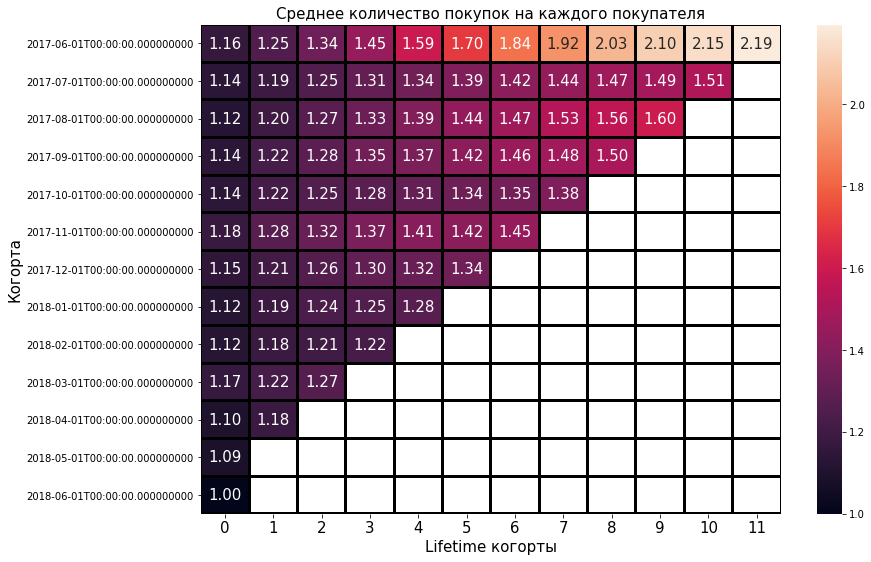

In [60]:
fig, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(orders_per_buyer_pivot, annot=True, fmt='.2f', linewidths=2,
            linecolor='black', ax=ax, annot_kws={'size': 15})
ax.set_title('Среднее количество покупок на каждого покупателя', fontsize=15)
ax.set_xlabel('Lifetime когорты', fontsize=15)
ax.set_ylabel('Когорта', fontsize=15)
plt.tick_params(labelsize=15, axis='x')
plt.show()

Среднее количество покупок на одного покупателя за 6 месяцев примерно одинаково во всех когортах (чуть более одной) с небольшим преимуществом когорты июня 2017 года. Выходит, что пользователи чаще используют сайт непосредственно для поиска мероприятий и лишь изредка делают покупки.

***

#### Найдём средний чек покупателя *revenue_per_buyer* — разделим показатель *revenue* на *n_orders*.

In [61]:
cohort_buyers['revenue_per_buyer'] = cohort_buyers['revenue'] / cohort_buyers['n_orders']

#### Построим сводную таблицу изменения среднего чека, где в столбцах будет lifetime, а строках — когорты.

In [62]:
revenue_per_buyer_pivot = (
    cohort_buyers
    .pivot_table(index='first_order_month',
                 columns='cohort_lifetime',
                 values='revenue_per_buyer')
)

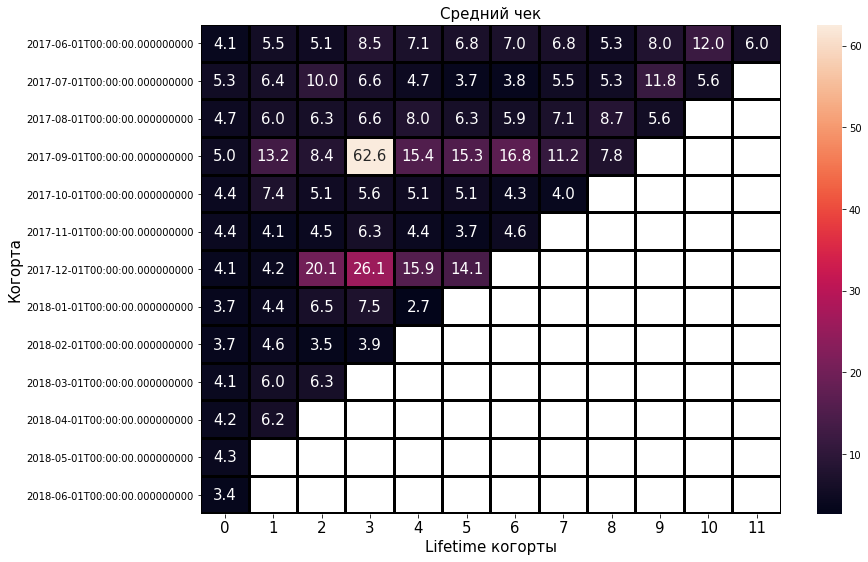

In [63]:
fig, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(revenue_per_buyer_pivot, annot=True, fmt='.1f', linewidths=2,
            linecolor='black', ax=ax, annot_kws={'size': 15})
ax.set_title('Средний чек', fontsize=15)
ax.set_xlabel('Lifetime когорты', fontsize=15)
ax.set_ylabel('Когорта', fontsize=15)
plt.tick_params(labelsize=15, axis='x')
plt.show()

Средний чек в когорте сентября 2017 составил более 62 у.е. в декабре. Когорта декабря 2017 расположилась на втором месте с дорогими покупками в феврале, марте, апреле и мае.

***

#### Получим количество новых покупателей за каждый месяц.

In [64]:
cohort_sizes = (
    cohort_buyers[['first_order_month', 'cohort_buyers']]
    .drop_duplicates()
    .reset_index(drop=True)
)

#### Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку.

In [65]:
cohort_ltv = (
    orders
    .groupby(['first_order_month', 'order_month'], as_index=False)
    .agg({'revenue': 'sum'})
)

#### Добавим в таблицу *cohort_ltv* данные о том, сколько людей первый раз совершили покупку в каждый месяц.

In [66]:
report_ltv = cohort_sizes.merge(cohort_ltv, on='first_order_month')

#### Найдём валовую прибыль, умножив выручку на маржинальность, и найдём «возраст» когорт.

In [67]:
margin_rate = 1
    
report_ltv['gp'] = report_ltv['revenue'] * margin_rate
report_ltv['cohort_lifetime'] = (
    (report_ltv['order_month'] - report_ltv['first_order_month']) / np.timedelta64(1, 'M')
).round().astype('int')

#### Найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте.

In [68]:
report_ltv['ltv'] = report_ltv['gp'] / report_ltv['cohort_buyers']
    
output_ltv = (
    report_ltv
    .pivot_table(index='first_order_month',
                 columns='cohort_lifetime',
                 values='ltv')
).cumsum(axis=1)

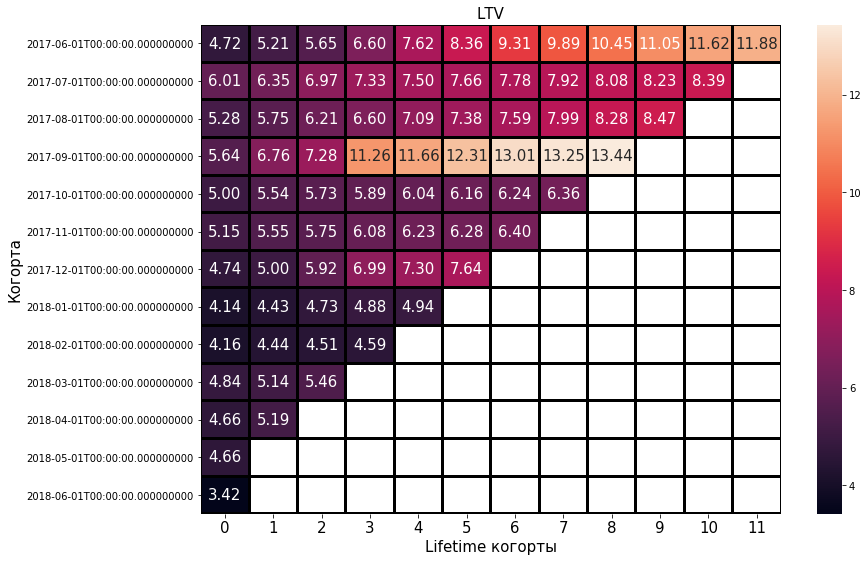

In [69]:
fig, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(output_ltv, annot=True, fmt='.2f', linewidths=2,
            linecolor='black', ax=ax, annot_kws={'size': 15})
ax.set_title('LTV', fontsize=15)
ax.set_xlabel('Lifetime когорты', fontsize=15)
ax.set_ylabel('Когорта', fontsize=15)
plt.tick_params(labelsize=15, axis='x')
plt.show()

По LTV вперёд вырывается когорта сентября 2017 за счёт дорогой декабрьской покупки. В среднем каждый покупатель из этой когорты принес более 12 у.е. за первые 6 месяцев.

### Вывод

Трое из четырёх пользователей сайта совершают покупку в первый же день.

Покупатели когорты июня 2017 выделяются большим ежемесячным количеством покупок, нежели остальные.

Активность покупателей когорты июня 2017 года растёт на протяжении 4 месяцев, после чего показывает довольно стабильный результат по сравнению с другими когортами. Рост в первые 2-3 месяца наблюдается у всех когорт.

Среднее количество покупок на одного покупателя за 6 месяцев примерно одинаково во всех когортах (чуть более одной) с небольшим преимуществом когорты июня 2017 года. Выходит, что пользователи чаще используют сайт непосредственно для поиска мероприятий и лишь изредка делают покупки.

Средний чек в когорте сентября 2017 составил более 62 у.е. в декабре. Когорта декабря 2017 расположилась на втором месте с дорогими покупками в феврале, марте, апреле и мае.

По **LTV** вперёд вырывается когорта сентября 2017 за счёт дорогой декабрьской покупки. В среднем каждый покупатель из этой когорты принес более 12 у.е. за первые 6 месяцев.

### <a id='marketing'>Маркетинговые метрики</a>

In [70]:
print('Всего потрачено на маркетинг:', costs['costs'].sum())

Всего потрачено на маркетинг: 329131.62


In [71]:
source_costs = (
    costs
    .pivot_table(index='source_id', values='costs', aggfunc='sum')
    .sort_values(by='costs', ascending=False)
)

source_costs

,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


In [72]:
show_pivot('source')

,daily_users,weekly_users,monthly_users
source_id,,,
4,275,1831,7766
3,233,1565,6759
5,176,1168,5018
2,121,716,2752
1,81,465,1819
9,36,238,987
10,26,167,707
6,1,1,1
7,1,1,3


Яндекс.Афиша значительно вкладывается в источник под номером 3 и это даёт свои плоды — вместе с источником под номерами 4 и 5 они приносят основной приток пользователей. Общая картина такова: чем больше вложения, тем больше приток пользователей. При этом 4 и 5 источники привлекают больше пользователей при гораздо меньших вложениях.

#### Посмотрим на распределения дат заказов и расходов.

In [73]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

In [74]:
costs['costs_date'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: costs_date, dtype: object

Диапазон дат расходов совпадает с датами заказов (1 июня 2017 — 31 мая 2018).

#### Выделим месяцы из дат в таблице с расходами.

In [75]:
costs['costs_month'] = costs['costs_date'].astype('datetime64[M]')

#### Найдём суммарные расходы за каждый месяц, а затем поделим их на количество покупателей в каждой когорте.

In [76]:
monthly_costs = costs.groupby('costs_month')['costs'].sum()
report_cac = pd.merge(report_ltv, monthly_costs, left_on='first_order_month', right_on='costs_month')
report_cac['cac'] = report_cac['costs'] / report_cac['cohort_buyers']

#### Посмотрим, как изменялись расходы на маркетинг и CAC во времени.

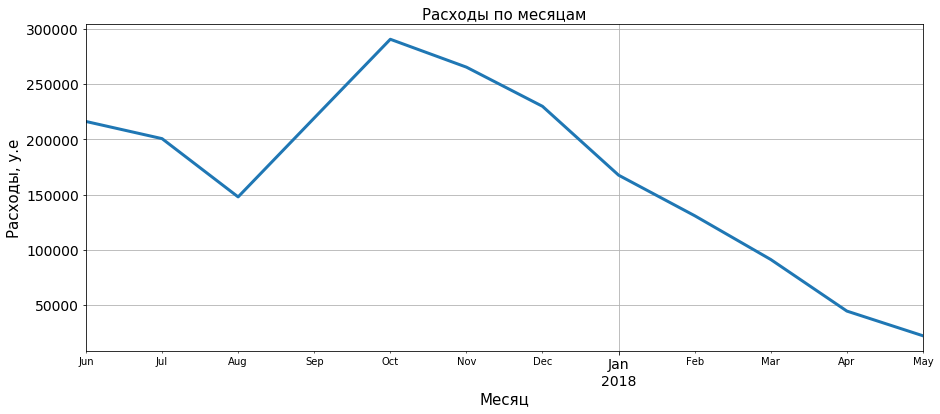

In [77]:
report_cac.groupby('first_order_month')['costs'].sum().plot(figsize=(15, 6), linewidth=3)
plt.title('Расходы по месяцам', fontsize=15)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Расходы, у.е', fontsize=15)
plt.tick_params(labelsize=14)
plt.grid()
plt.show()

Яндекс.Афиша знатно потратилась на маркетинг в октябре 2017 года. Неудивительно, что именно в эти месяцы наблюдается приток пользователей. Далее расходы пошли на спад.

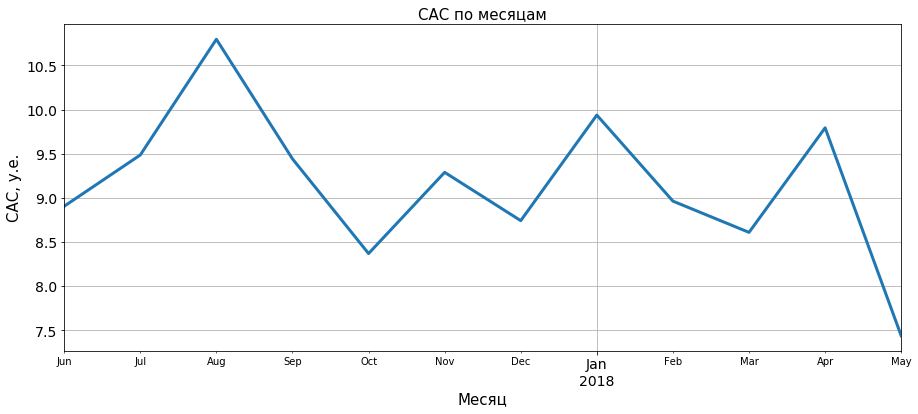

In [78]:
report_cac.groupby('first_order_month')['cac'].mean().plot(figsize=(15, 6), linewidth=3)
plt.title('CAC по месяцам', fontsize=15)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('CAC, у.е.', fontsize=15)
plt.tick_params(labelsize=14)
plt.grid()
plt.show()

В отличие от расходов на маркетинг, CAC на протяжении рассматриваемого периода нестабилен. Пики наблюдаются в августе, ноябре, январе и апреле. В остальные месяцы наблюдается спад.

#### Рассчитаем средний CAC на одного покупателя для всего проекта и для каждого источника трафика.

In [79]:
print('Средний CAC на одного покупателя для всего проекта:', report_cac['cac'].mean().round(2))

Средний CAC на одного покупателя для всего проекта: 9.32


In [80]:
cac_by_source = (
    pd.merge(costs.groupby('source_id', as_index=False).agg({'costs': 'sum'}),
             orders.groupby('source_id', as_index=False).agg({'uid': 'nunique'})
             .rename(columns={'uid': 'n_buyers'}),
             on='source_id')
    .assign(cac = lambda row: row['costs'] / row['n_buyers'])[['source_id', 'cac']]
    .sort_values(by='cac', ascending=False)
    .reset_index(drop=True)
)

cac_by_source

,source_id,cac
0,3,13.493901
1,2,12.209367
2,5,7.467479
3,1,7.186364
4,4,5.931779
5,9,5.071222
6,10,4.381106


In [81]:
orders['costs_date'] = orders['first_order_ts'].astype('datetime64[D]')

orders_grouped = (
    orders
    .groupby(['source_id', 'costs_date'], as_index=False)
    .agg({'uid': 'nunique', 'revenue': 'sum'})
)

orders_grouped = orders_grouped.merge(costs, on=['source_id', 'costs_date'])

orders_grouped['cac'] = orders_grouped['costs'] / orders_grouped['uid']

cohort_cac_by_source = orders_grouped\
.pivot_table(index='costs_month',
             columns='source_id',
             values='cac')

cohort_cac_by_source

source_id,1,2,3,4,5,9,10
costs_month,,,,,,,
2017-06-01,11.681283,12.883568,16.716919,10.792094,9.209676,5.253654,4.590158
2017-07-01,9.491485,18.000253,18.593952,8.054482,7.938157,5.582433,6.151880
2017-08-01,12.118898,18.886449,19.795068,11.554926,6.879620,4.900254,5.813398
2017-09-01,8.155731,17.672249,13.084043,9.533800,6.864844,6.049126,8.306581
2017-10-01,8.202083,14.193003,14.613088,6.233562,6.305969,5.923235,6.362921
2017-11-01,8.908503,17.437690,16.091445,5.013132,9.368019,9.400503,10.801337
2017-12-01,8.570439,13.871086,12.948321,5.656507,8.399174,7.899420,7.803197
2018-01-01,11.719181,15.850151,15.134989,5.901092,9.371755,9.792713,9.851557
2018-02-01,10.752216,18.209325,13.894612,5.428068,7.725369,8.181382,4.489624


In [82]:
show_pivot('source')

,daily_users,weekly_users,monthly_users
source_id,,,
4,275,1831,7766
3,233,1565,6759
5,176,1168,5018
2,121,716,2752
1,81,465,1819
9,36,238,987
10,26,167,707
6,1,1,1
7,1,1,3


В разрезе источников трафика наибольший CAC у источника под номером 3, следом идёт 2-ой источник. Наименьший CAC у 9-го и 10-го источников, причём он сопостовим с CAC источника под номером 4, который приносит на порядок больше пользователей.

При этом приток пользователей из источника 4 наивысший, а приток из источника 5 сопостовим с притоком из источника 3. CAC на одного покупателя из этих источников при этом вдвое меньше, чем у источника под номером 3.

***

#### Рассчитаем ROMI: поделим LTV на CAC.

In [83]:
report_cac['romi'] = report_cac['ltv'] / report_cac['cac']

output_romi = (
    report_cac
    .pivot_table(index='first_order_month',
                 columns='cohort_lifetime',
                 values='romi')
).cumsum(axis=1)

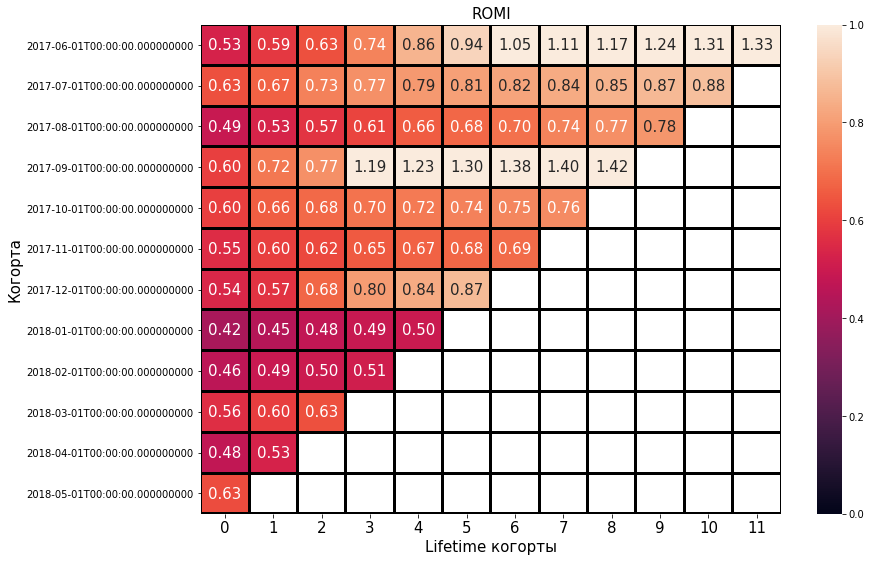

In [84]:
fig, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(output_romi, annot=True, fmt='.2f', linewidths=2, 
            linecolor='black', vmin=0, vmax=1, ax=ax, annot_kws={'size': 15})
ax.set_title('ROMI', fontsize=15)
ax.set_xlabel('Lifetime когорты', fontsize=15)
ax.set_ylabel('Когорта', fontsize=15)
plt.tick_params(labelsize=15, axis='x')
plt.show()

Когорта сентября 2017 года окупилась на 4 месяц (ROMI = 1.19). Когорта июня 2017 года окупилась на 7 месяц (ROMI = 1.05). Остальные когорты всё ещё не окупились.

#### Узнаем, на какой месяц в среднем окупаются когорты.

In [85]:
output_romi.mean(axis=0).round(2)

cohort_lifetime
0     0.54
1     0.58
2     0.63
3     0.72
4     0.78
5     0.86
6     0.90
7     0.97
8     1.05
9     0.96
10    1.09
11    1.33
dtype: float64

В среднем когорты окупаются к концу 10-го lifetime, то есть 11-го месяца.

#### Рассчитаем ROMI по когортам в разрезе источников. Найдём выручку в разрезе источника, когорты и месяца покупки.

In [86]:
revenue_by_source_month = (
    orders
    .groupby(['source_id', 'first_order_month', 'order_month'], as_index=False)
    .agg({'revenue': 'sum'})
)

#### Найдём размер когорт в разрезе источника и месяца первой покупки.

In [87]:
cohort_sizes = (
    orders
    .groupby(['source_id', 'first_order_month'], as_index=False)
    .agg({'uid': 'nunique'})
    .rename(columns={'uid': 'cohort_sizes'})
)

#### Объединим таблицы *revenue_by_source_month*, *cac_by_source* и *cohort_sizes* и посчитаем LTV, lifetime и ROMI.

In [88]:
report_romi = (
    pd.merge(revenue_by_source_month,
            cac_by_source, 
             on='source_id')
    .merge(cohort_sizes, 
           on=['source_id', 'first_order_month'])
    .assign(ltv = lambda row: row['revenue'] / row['cohort_sizes'])
    .assign(cohort_lifetime = lambda row: (
        (row['order_month'] - row['first_order_month']) / np.timedelta64(1, 'M')
    ).round().astype(int))
    .assign(romi = lambda row: row['ltv'] / row['cac'])
)

#### Сформируем сводные таблицы с расчётом ROMI по источникам трафика.

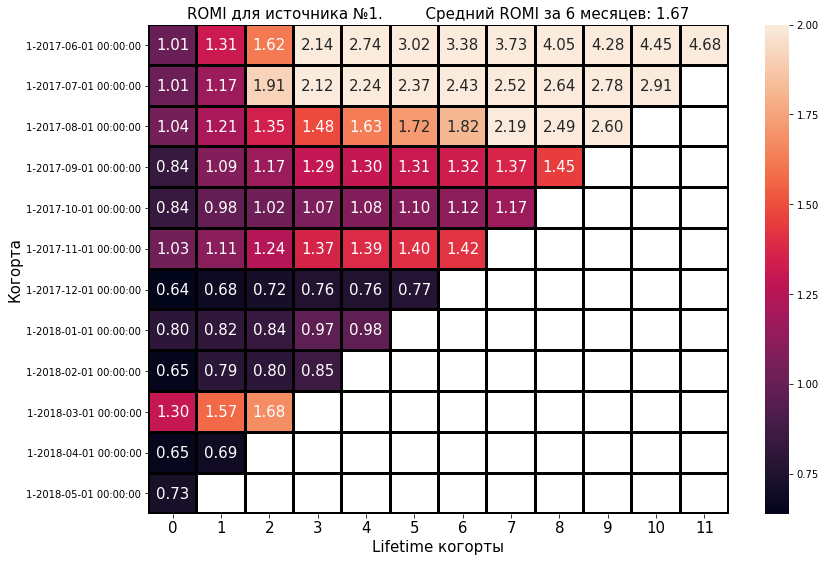

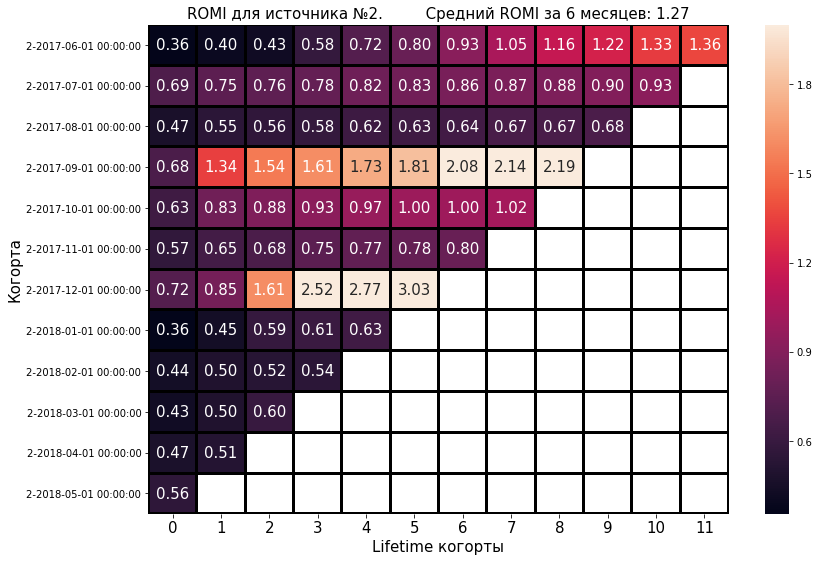

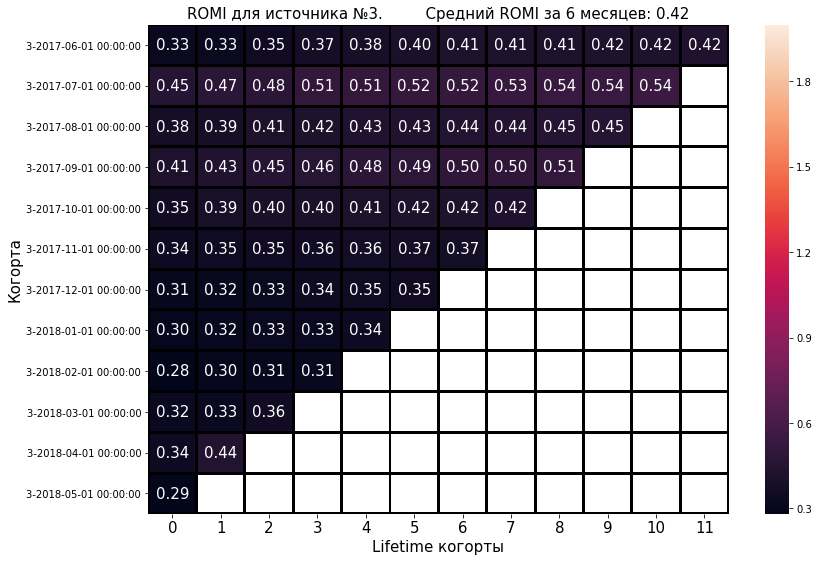

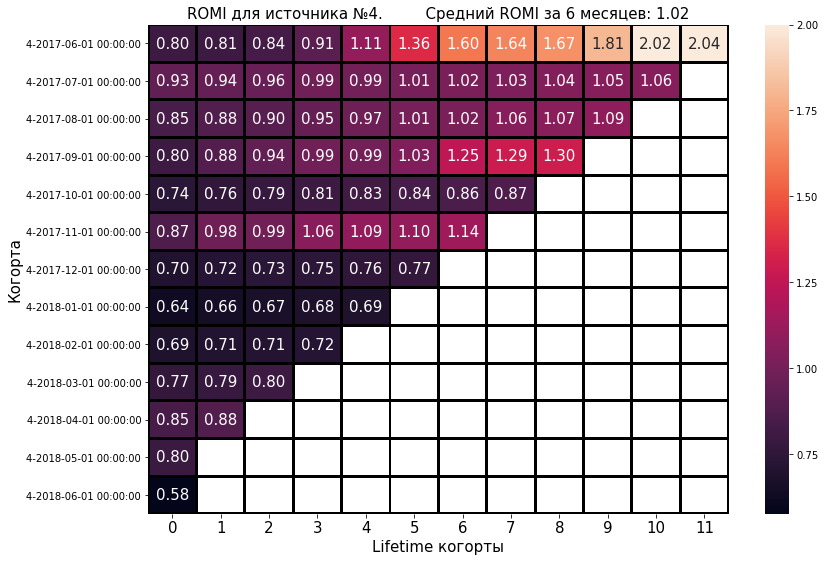

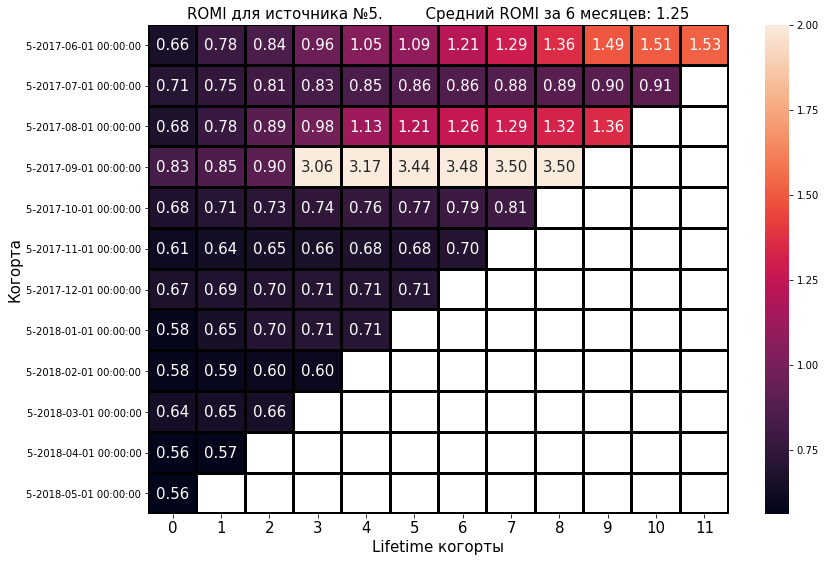

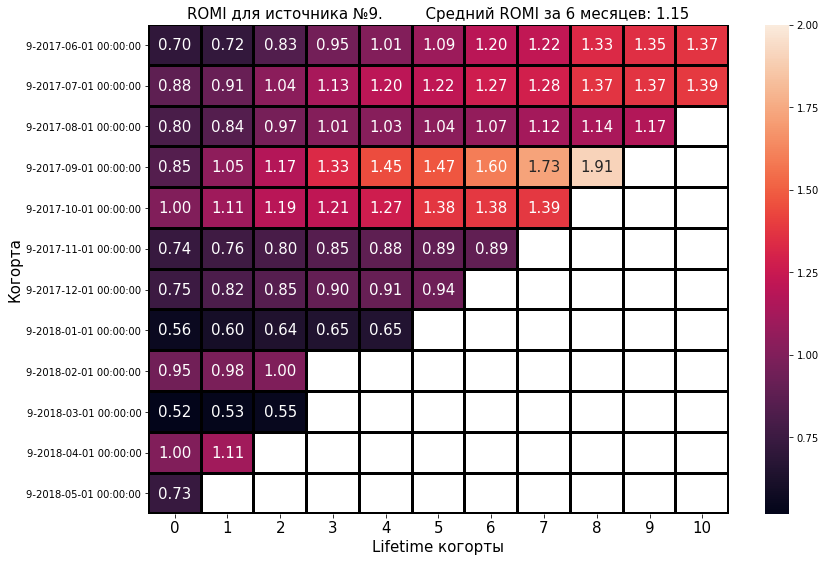

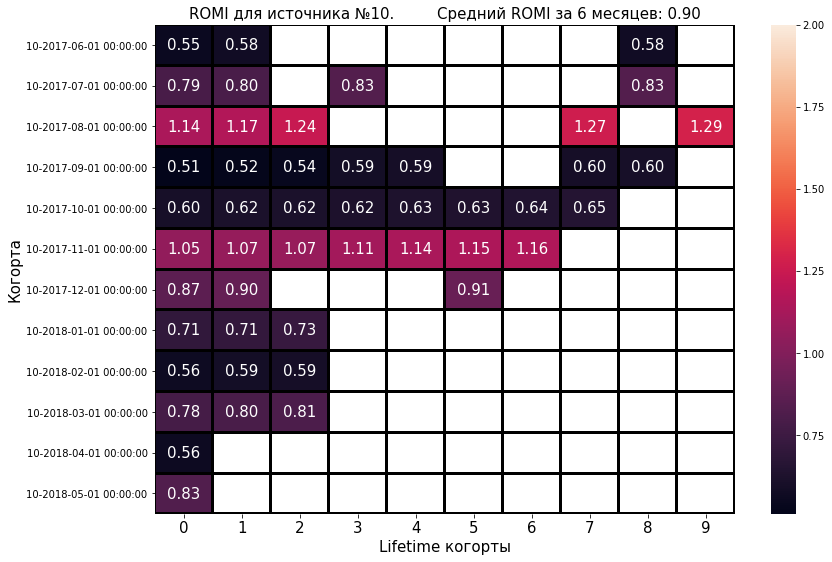

In [89]:
for source in report_romi['source_id'].unique():
    output_romi_by_source = (
        report_romi.query("source_id == @source")
        .pivot_table(index=['source_id', 'first_order_month'],
                     columns='cohort_lifetime',
                     values='romi')
    ).cumsum(axis=1)
    fig, ax = plt.subplots(figsize=(13, 9))
    sns.heatmap(output_romi_by_source, annot=True, fmt='.2f', linewidths=2,
                linecolor='black', vmax=2, ax=ax, annot_kws={'size': 15})
    ax.set_title(
        f'ROMI для источника №{source}. \
        Средний ROMI за 6 месяцев: {output_romi_by_source.iloc[:, 5].mean():.2f}',
        fontsize=15
    )
    ax.set_ylabel('Когорта', fontsize=15)
    ax.set_xlabel('Lifetime когорты', fontsize=15)
    plt.tick_params(labelsize=15, axis='x')
    plt.show()

Рентабельность источника под номером 1 впечатляет. Во многих когортах он окупил себя мгновенно и продолжает демонстрировать отличную динамику ROMI. Заметим, что богатые клиенты сентябрьской когорты пришли из источника под номером 5. Источник под номером 4 хорош и стабилен. Источник под номером 3 совершенно не рентабелен.

### Вывод

Всего потрачено на маркетинг 329 131 у.е. 

Яндекс.Афиша значительно вкладывается в источник под номером 3 и это даёт свои плоды — вместе с источником под номерами 4 и 5 они приносят основной приток пользователей. Общая картина такова: чем больше вложения, тем больше приток пользователей. При этом 4 и 5 источники привлекают больше пользователей при гораздо меньших вложениях.

Яндекс.Афиша знатно потратилась на маркетинг в октябре 2017 года. Неудивительно, что именно в эти месяцы наблюдается приток пользователей. Далее расходы пошли на спад.

В отличие от расходов на маркетинг, CAC на протяжении рассматриваемого периода нестабилен. Пики наблюдаются в августе, ноябре, январе и апреле. В остальные месяцы наблюдается спад.

Средний **CAC** на одного покупателя для всего проекта: 9.3 у.е.

В разрезе источников трафика наибольший CAC у источника под номером 3, следом идёт 2-ой источник. Наименьший CAC у 9-го и 10-го источников, причём он сопостовим с CAC источника под номером 4, который приносит на порядок больше пользователей. Источники 6 и 7 вообще можно не рассматривать.

При этом приток пользователей из источника 4 наивысший, а приток из источника 5 сопостовим с притоком из источника 3. CAC на одного покупателя из этих источников при этом вдвое меньше, чем у источника под номером 3.

Когорта сентября 2017 года окупилась на 4 месяц (**ROMI = 1.19**). Когорта июня 2017 года окупилась на 7 месяц (**ROMI = 1.05**). Остальные когорты всё ещё не окупились. В среднем когорты окупаются к концу 11-го месяца.

Рентабельность источника под номером 1 впечатляет. Во многих когортах он окупил себя мгновенно и продолжает демонстрировать отличную динамику ROMI. Заметим, что богатые клиенты сентябрьской когорты пришли из источника под номером 5. Источник под номером 4 хорош и стабилен. Источник под номером 3 совершенно не рентабелен.

## <a id='recommendation'>Шаг 3.  Выводы и рекомендации</a>

1. Стоит вложиться в источники под номерами 4 и 5. Они приносят много клиентов при относительно низких затратах (**CAC**). Также рентабельность (**ROMI**) 1-го источника впечатляет. Он показывает лучшую динамику за 6 месяцев. Не стоит вкладывать большие деньги в источники под номерами 2 и 3. Яндекс.Афиша вкладывает в них вдвое больше денег, чем в источники 4 и 5, но даже при этом приток пользователей из них меньше. Источник под номером 3 не окупил себя ни в одной когорте покупателей.
2. Выводы по продукту, электронной коммерции и маркетингу:
    - Лояльность посетителей сайта плохая, однако высоких показателей здесь и не ожидалось. **Retention Rate** достаточно низкий во всех когортах. Продолжительность одной сессии — около 5 минут.
    - Трое из четырёх пользователей сайта совершают покупку в первый же день. Среднее количество покупок на одного покупателя за 6 месяцев примерно одинаково во всех когортах — чуть более одной в месяц. По среднему чеку и **LTV** вперёд вырывается когорта сентября 2017 за счёт дорогих декабрьских покупок.
    - Средний **CAC** на одного покупателя для всего проекта: 9.3 у.е. В разрезе источников трафика наибольший **CAC** у источника под номером 3, следом идёт 2-ой источник. Наименьший CAC у 9-го и 10-го источников.
3. Самые перспективные когорты — когорты июня 2017 и сентября 2017. Первые полюбили сайт и возвращаются чаще остальных, а вторые покупают дорого. К тому же обе когорты окупили себя гораздо быстрее (**ROMI** перевалил за 1 уже на 4 и 7 месяцы соответственно), чем средняя когорта (окупается к концу 11 месяца). К когорте декабря 2017 года тоже стоит присмотреться. Их средний чек растёт очень быстро последние 4 месяца.